# 프로젝트: 인물 모드 문제점 찾기

**학습목표**

딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

### Step 1. 인물모드 직접 해 보기


여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.

인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [264]:
# 필요한 라이브러리 임포트
import os
import urllib # urllib는 웹에서 데이터를 다운로드할 때 사용
import cv2 # cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation 
# pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

**사람 이미지 해보기**

(720, 680, 3)


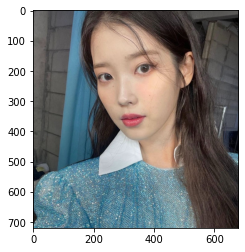

In [265]:
# 준비한 이미지를 읽습니다
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.

i_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.png'  
i_img_orig = cv2.imread(i_img_path) 

print(i_img_orig.shape)
plt.imshow(cv2.cvtColor(i_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

시맨틱 세그멘테이션으로 사람 분리 해보기

In [266]:
# DeepLab 모델을 준비 PixelLib를 이용하면 편하게 사용
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다 # 아까 앞에서 경로 지정할때 있던거
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc5722909a0>)

In [267]:
# PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [268]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(i_img_path)
# segmentAsPascalvoc() : PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미
# PASCAL VOC : image detection을 위한 dataset으로 classification, object detection, 
# segmentation 평가 알고리즘을 구축하거나 평가하는데 매우 유명한 데이터 셋.

model.segmentAsPascalvoc(di_img_path, dh_img_path, jy_img_path) 3가지를 한번에 넣어봤더니
Processed Image saved successfuly in your current working directory 라고 뜸 하나만 넣으면 저런 문구 뜨지 않았음
해석해보면 처리된 이미지가 현재 작업 디렉토리에 성공적으로 저장되었습니다. 3가지가 다 저장이 되었다는 뜻인까?

그냥 하나씩 하기로 했다

In [269]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) 

21

0부터 20까지 21가지 지정

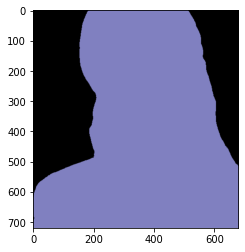

In [270]:
# 모델에서 나온 출력값 알아보기
plt.imshow(output)
plt.show() # output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요

In [271]:
# segvalues에는 class_ids와 masks가 있습니다
segvalues 

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

0은 background 15는 person

In [272]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) # class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요

background
person


In [273]:
# 물체마다 output에 어떤 색상으로 나타나 있는지만 알아보자
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] # 20가지 색상 나타냄

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [274]:
# 사람을 나타내는 15
colormap[15] # [192, 128, 128]
# 주의할 점은 output 이미지는 BGR 순서로 채널 배치 colormap은 RGB 순서임

array([192, 128, 128])

In [275]:
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다
seg_color = (128,128,192) # 색순서 바꿔주기

(720, 680)


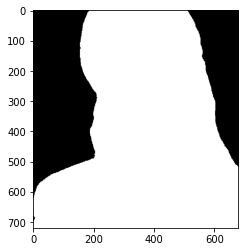

In [276]:
# seg_color로만 이루어진 마스크를 만들어 보자
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

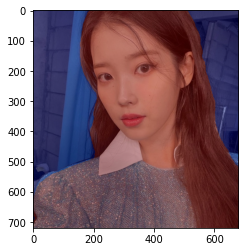

In [277]:
# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬움
i_img_show = i_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
i_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(i_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
i_img_show = cv2.addWeighted(i_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(i_img_show, cv2.COLOR_BGR2RGB))
plt.show()

배경 흐리게 하기

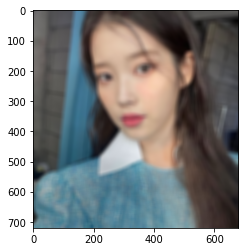

In [278]:
# blur() 함수를 이용해서 배경을 흐리게 만듭니다
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
i_img_orig_blur = cv2.blur(i_img_orig, (17,17)) # 숫자 크게 하니까 더 흐려짐
plt.imshow(cv2.cvtColor(i_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

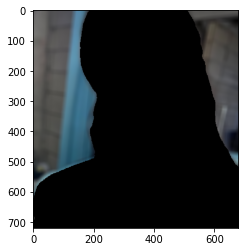

In [279]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
i_img_mask_color = cv2.cvtColor(i_img_mask, cv2.COLOR_GRAY2BGR)
i_img_bg_mask = cv2.bitwise_not(i_img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전
# 원래 마스크에서는 배경이 0, 사람이 255 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
i_img_bg_blur = cv2.bitwise_and(i_img_orig_blur, i_img_bg_mask)
plt.imshow(cv2.cvtColor(i_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 그래서 사람이 사라짐

흐린 배경과 원본 영상 합성

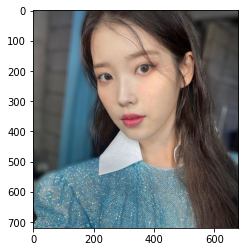

In [280]:
# 배경 영상과 사람 영상을 합치기
i_img_concat = np.where(i_img_mask_color==255, i_img_orig, i_img_bg_blur)
plt.imshow(cv2.cvtColor(i_img_concat, cv2.COLOR_BGR2RGB))
plt.show()
# 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. 
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용
# 앞사진 배경 블러된 사진, 뒷사진 원본 사진

**고양이 이미지 해보기**

(801, 599, 3)


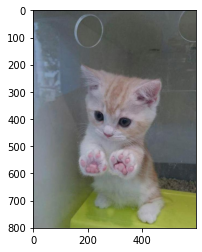

In [281]:
# 준비한 이미지를 읽습니다
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.

cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_face.jpg'  
cat_img_orig = cv2.imread(cat_img_path) 

print(cat_img_orig.shape)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

시맨틱 세그멘테이션으로 사람 분리 해보기

In [282]:
# DeepLab 모델을 준비 PixelLib를 이용하면 편하게 사용
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다 # 아까 앞에서 경로 지정할때 있던거
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc5685e5ac0>)

In [283]:
# PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [284]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(cat_img_path)
# segmentAsPascalvoc() : PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미
# PASCAL VOC : image detection을 위한 dataset으로 classification, object detection, 
# segmentation 평가 알고리즘을 구축하거나 평가하는데 매우 유명한 데이터 셋.

In [285]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) 

21

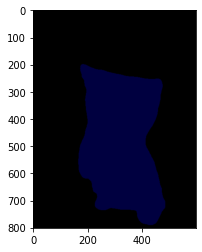

In [286]:
# 모델에서 나온 출력값 알아보기
plt.imshow(output)
plt.show() # output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요

In [287]:
# segvalues에는 class_ids와 masks가 있습니다
segvalues 

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

8번은 고양이 제대로 인식함

In [288]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) # class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요

background
cat


In [289]:
# 물체마다 output에 어떤 색상으로 나타나 있는지만 알아보자
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] # 20가지 색상 나타냄

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [290]:
# 사람을 나타내는 15
colormap[8] # [192, 128, 128]
# 주의할 점은 output 이미지는 BGR 순서로 채널 배치 colormap은 RGB 순서임

array([64,  0,  0])

In [291]:
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다
seg_color = (0,0,64) # 색순서 바꿔주기

(801, 599)


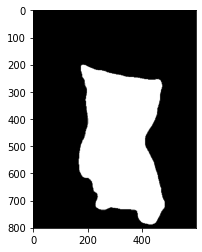

In [292]:
# seg_color로만 이루어진 마스크를 만들어 보자
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

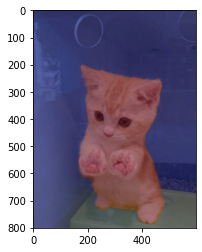

In [293]:
# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬움
cat_img_show = cat_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cat_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

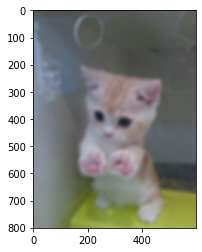

In [294]:
# blur() 함수를 이용해서 배경을 흐리게 만듭니다
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
cat_img_orig_blur = cv2.blur(cat_img_orig, (17,17)) # 숫자 크게 하니까 더 흐려짐
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

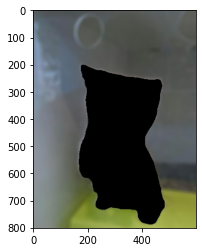

In [295]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전
# 원래 마스크에서는 배경이 0, 사람이 255 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

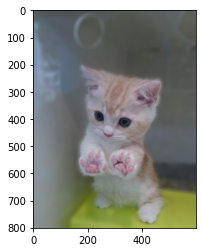

In [296]:
# 배경 영상과 사람 영상을 합치기
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()
# 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. 
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용
# 앞사진 배경 블러된 사진, 뒷사진 원본 사진

배경으로 사용할 이미지 불러오기

(1050, 700, 3)


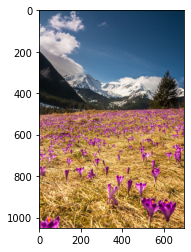

In [297]:
b_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'  
b_img_orig = cv2.imread(b_img_path)

print(f_img_orig.shape)
plt.imshow(cv2.cvtColor(b_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(720, 680, 3)


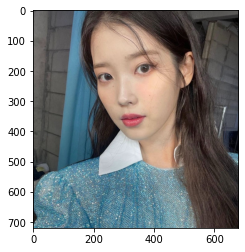

In [298]:
i_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.png'  
i_img_orig = cv2.imread(i_img_path) 

print(i_img_orig.shape)
plt.imshow(cv2.cvtColor(i_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

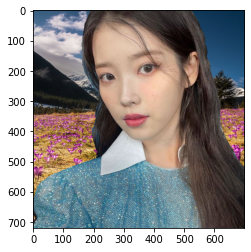

In [299]:
# 사람 이미지, 배경 이미지, 이미지 mask 리사이즈
i_resized = cv2.resize(i_img_orig, (b_img_orig.shape[1], i_img_orig.shape[0]))
b_img_resized = cv2.resize(b_img_orig, (b_img_orig.shape[1], i_img_orig.shape[0]))

i_img_mask_resized = cv2.resize(i_img_mask_color, (b_img_orig.shape[1], i_img_orig.shape[0]))

# 배경 이미지과 사람 이미지을 합치기
i_b_concat = np.where(i_img_mask_resized == 255, i_resized, b_img_resized)

plt.imshow(cv2.cvtColor(i_b_concat, cv2.COLOR_BGR2RGB))
plt.show()

머리카락부분의 경계선이 부자연스럽게 나타남 합성이 제대로 되지 않아서 색깔 이상하게 나오는 부분이 있음

**가우시안 블러(GaussianBlur)로 해보기**

중앙값에 가중치를 더 주고 주변은 더 흐리게 하는 가우시안 블러를 사용해보겠음

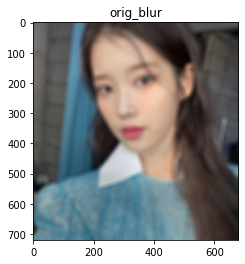

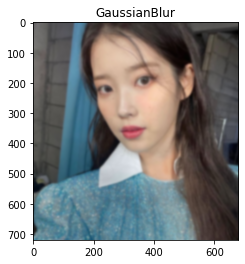

In [300]:
i_img_orig_blur = cv2.blur(i_img_orig, (17,17)) # 숫자 크게 하니까 더 흐려짐
plt.imshow(cv2.cvtColor(i_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.title('orig_blur')
plt.show()

i_img_gaublur = cv2.GaussianBlur(i_img_orig, (17,17), 0) # 숫자 크게 하니까 더 흐려짐
plt.imshow(cv2.cvtColor(i_img_gaublur, cv2.COLOR_BGR2RGB))
plt.title('GaussianBlur')
plt.show()



어느 정도 차이점이 느껴진다

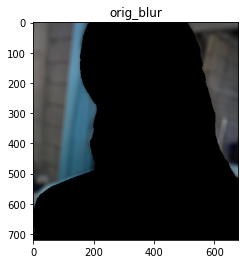

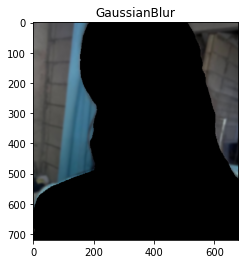

In [301]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
i_img_mask_color = cv2.cvtColor(i_img_mask, cv2.COLOR_GRAY2BGR)
i_img_bg_mask = cv2.bitwise_not(i_img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전
# 원래 마스크에서는 배경이 0, 사람이 255 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
i_img_bg_blur = cv2.bitwise_and(i_img_orig_blur, i_img_bg_mask)
plt.title('orig_blur')
plt.imshow(cv2.cvtColor(i_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
i_img_mask_color = cv2.cvtColor(i_img_mask, cv2.COLOR_GRAY2BGR)
i_img_bg_mask = cv2.bitwise_not(i_img_mask_color) # bitwise_not 함수를 이용하면 이미지가 반전
# 원래 마스크에서는 배경이 0, 사람이 255 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
i_img_gaublur = cv2.bitwise_and(i_img_gaublur, i_img_bg_mask)
plt.title('GaussianBlur')
plt.imshow(cv2.cvtColor(i_img_gaublur, cv2.COLOR_BGR2RGB))
plt.show()

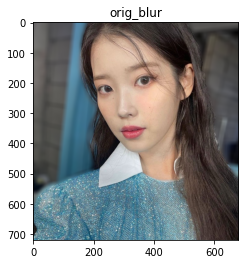

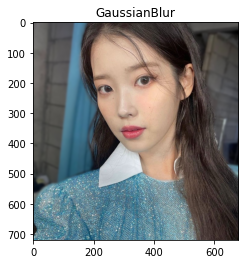

In [302]:
# 배경 영상과 사람 영상을 합치기
i_img_concat_b = np.where(i_img_mask_color==255, i_img_orig, i_img_bg_blur)
plt.imshow(cv2.cvtColor(i_img_concat_b, cv2.COLOR_BGR2RGB))
plt.title('orig_blur')
plt.show()

# 배경 영상과 사람 영상을 합치기
i_img_concat_g = np.where(i_img_mask_color==255, i_img_orig, i_img_gaublur)
plt.imshow(cv2.cvtColor(i_img_concat_g, cv2.COLOR_BGR2RGB))
plt.title('GaussianBlur')
plt.show()


**회고**

시맨틱 세그멘테이션 다뤄보기를 보면 PixelLib가 있는데 여기 튜토리얼에서 그림으로 이미지의 배경 변경하는 것을 계속 시도해보고 있으나 진행이 되질 않는다. 이것 저것 찾아보는데 진행 되지 않음. 라이브러리 설치해도 안됨. 아무리 해도 되지않음..... 사진 만지작 만지작 하는거라 재밌긴한데 뭐하나 되는게 없으니..